# Polarization reconstruction debugging (almost there!!)

### Oct 6, 2020

## Code

In [44]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")

In [45]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

# import mplcyberpunk
# plt.style.use("cyberpunk")

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Define function

In [3]:

def random_three_vector():
    """
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    :return:
    """
    phi = np.random.uniform(0,2*np.pi)
#     costheta = np.random.uniform(0,1)
#     costheta = 0
#     theta = np.arccos( costheta )
    theta = np.random.uniform(0,np.pi/2)
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos(theta)
    return np.array([x,y,z])

In [4]:
# phi = np.deg2rad(90)
# theta = np.deg2rad(90)
from scipy import signal
pol_ev = np.array([0.,0,1])
dirProp = np.array([0,1,0])
# pol_ev = np.array([0.73464503,0.66096714,0.15303304])
# dirProp = np.array([0.12301928,0.09204764,0.98812625])

# dirProp = random_three_vector()
phi = np.arctan2(dirProp[1],dirProp[0])
print("phi:%0.2f"%phi)
theta = np.arccos(dirProp[2])
print("theta:%0.2f"%np.degrees(theta))

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")

sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
# antV.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
output = antV.front_end(sig)

timeV = output.times*1E9 #in ns
voltageV = output.values*1E3 #in mV

phi:1.57
theta:90.00


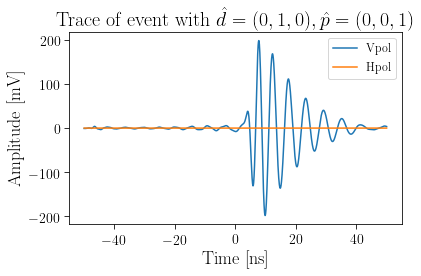

In [5]:
# plt.figure(figsize=(6,3))
sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
antH.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
outputH = antH.front_end(sigH)
timeH = outputH.times*1E9 #in ns
voltageH = outputH.values*1E3 #in mV

plt.plot(timeV,voltageV, label="Vpol")
plt.plot(timeH,voltageH, label="Hpol")
plt.title("Trace of event with $\hat{d}=(0,1,0), \hat{p}=(0,0,1)$")
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [mV]")
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Stokes/Sep30Call/trace_example.pdf')

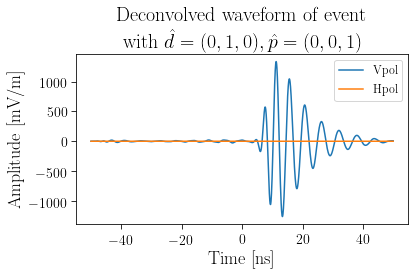

In [6]:
deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)
plt.plot(deConv_V_t,deConv_V_v, label = "Vpol")
plt.plot(deConv_H_t,deConv_H_v, label = "Hpol")
plt.legend()
plt.title("Deconvolved waveform of event \n with $\hat{d}=(0,1,0), \hat{p}=(0,0,1)$")
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [mV/m]")
plt.tight_layout()
# plt.savefig(my_path_plots+'/Stokes/Sep30Call/deconvolved_example.pdf')

### Calculate polarization angle from Stokes parameters

In [7]:
def PolAngleStokes(Hpol,Vpol):
    return np.degrees(0.5*np.arctan2(2*Hpol*Vpol,(Vpol**2-Hpol**2)))
def PolRatio(Hpol,Vpol):
    return np.degrees(np.arctan2(Hpol,Vpol))

In [8]:
random_three_vector()

array([ 0.25005012, -0.56921577,  0.7832422 ])

# Generate random polarizations

In [40]:
reco=[]
true=[]
phi_ = []
dot = []
np.random.seed(0)

antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, -100), power_threshold=0)
antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, -100), power_threshold=0)
# antV.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
# antH.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")
for count in range(0,1000):
#     dirProp = np.array([ 0.08984711, -0.35410375,  0.93088025])
    pol_ev =  random_three_vector()
    dirProp = random_three_vector()  # take a random vector
    dirProp -= dirProp.dot(pol_ev) * pol_ev       # make it orthogonal to k
    dirProp /= np.linalg.norm(dirProp) 
#     phi2 = np.arctan2(dirProp[1],dirProp[0]) % (2*np.pi)
#     theta2 = np.arccos(dirProp[2])
#     pol_ev=np.array([-np.sin(theta2)/np.cos(phi2),-np.cos(theta2)**2/(np.sin(theta2)*np.sin(phi2)),1/np.cos(theta2)])
    
    _, theta, phi = antV.antenna._convert_to_antenna_coordinates(antV.position - normalize(dirProp))
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos(theta)
    newdirProp = np.array([x,y,z])
    y_axis = np.cross(antV.antenna.z_axis, antV.antenna.x_axis)
    transformation = np.array([antV.antenna.x_axis, y_axis, antV.antenna.z_axis])
    ant_pol = np.dot(transformation, normalize(pol_ev))
#     pol_ev2 = np.random.randn(3)  # take a random vector
#     pol_ev2 -= pol_ev.dot(newdirProp) * newdirProp       # make it orthogonal to k
#     pol_ev2 /= np.linalg.norm(pol_ev2) 
#     phi = np.arctan2(dirProp[1],dirProp[0])
#     theta = np.arccos(dirProp[2])
#     pol_ev = random_three_vector()
    
    sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
    sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
    output = antV.front_end(sig)

    timeV = output.times*1E9 #in ns
    voltageV = output.values*1E3 #in mV

    sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

    sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
    outputH = antH.front_end(sigH)
    timeH = outputH.times*1E9 #in ns
    voltageH = outputH.values*1E3 #in mV

    deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
    deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)
    reco_ = PolRatio(max(abs(voltageH)),max(abs(voltageV)))
    true_ = np.degrees(np.arccos(ant_pol[2]))
#     if(np.dot(newdirProp,ant_pol)>0.1):
#         print(np.dot(newdirProp,ant_pol)>0.1)
# #         break
#     if(reco_-true_>100):
# # #         continue
# # #         true_=abs(90-true_)
#     if(reco_-true_<-60):
#         print("dir_prop:%s"%newdirProp)
#         print("pol_vec:%s"%ant_pol)
#         print("Max values (H,V): (%0.3f, %0.3f)"%(max(abs(deConv_H_v)),max(abs(deConv_V_v))))
#         print("theta_reco:%0.3f"%reco_)
#         print("theta_true:%0.3f"%true_)
# #         print(np.degrees(np.arccos(pol_ev[2])))
#         print("Dot product is %f"%np.dot(newdirProp,ant_pol))
# #         plt.plot(deConv_V_t,deConv_V_v,label="Vpol")
# #         plt.plot(deConv_H_t,deConv_H_v, label="Hpol")
#         plt.figure()
#         plt.plot(timeV,voltageV,label="Vpol")
#         plt.plot(timeH,voltageH, label="Hpol")
#         plt.xlabel("Time [ns]")
#         plt.ylabel("Amplitude [mV]")
#         plt.legend()
#         plt.tight_layout()
# #         plt.savefig(my_path_plots+'/Stokes/Sep30Call/trace_example_RightTail.pdf')
#         plt.figure()
#         plt.plot(deConv_V_t,deConv_V_v,label="Vpol")
#         plt.plot(deConv_H_t,deConv_H_v, label="Hpol")
#         plt.xlabel("Time [ns]")
#         plt.ylabel("Amplitude [mV/m]")
#         plt.legend()
#         plt.tight_layout()
# #         plt.savefig(my_path_plots+'/Stokes/Sep30Call/deconvolved_example_RightTail.pdf')
#         break

    reco.append(reco_)
    true.append(true_)
    phi_.append(np.degrees(phi))
    dot.append(np.dot(newdirProp,ant_pol))
#     print((PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))-np.degrees(theta)))

In [41]:
PolRatio(max(abs(voltageV)),max(abs(voltageH)))

35.467971100806366

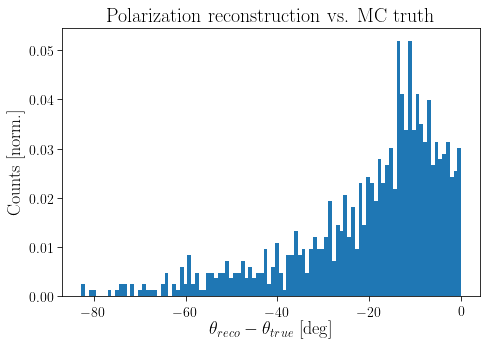

In [42]:
reco=np.array(reco)
true=np.array(true)
phi_=np.array(phi_)
plt.figure(figsize=(7,5))
plt.hist(reco-true, bins=100, density=True, alpha=1);

plt.xlabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
# plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_MC.pdf')

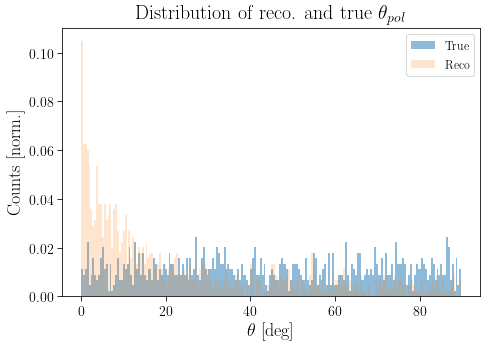

In [43]:
plt.figure(figsize=(7,5))
plt.hist(true, bins=200, density=True, alpha=0.5,label="True");
plt.hist(reco, bins=200, density=True, alpha=0.2,label="Reco");

# plt.xlabel("$\\theta_{reco}-abs(\\theta_{true})$")
plt.xlabel("$\\theta$ [deg]")
plt.ylabel('Counts [norm.]')
plt.title("Distribution of reco. and true $\\theta_{pol}$")
# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.legend()
# plt.show()

# plt.savefig(my_path_plots+'/Dumpster/recoandTrueDist.pdf')

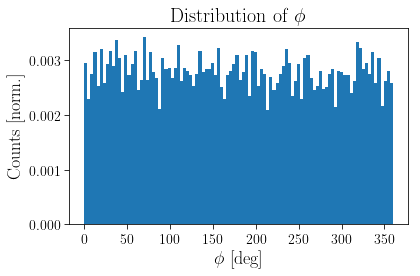

In [34]:
# plt.figure(figsize=(7,5))
plt.hist(phi_, bins=100, density=True);
# plt.hist(reco, bins=100, density=True, alpha=0.2,label="Reco");

plt.xlabel("$\\phi$ [deg]")
plt.ylabel('Counts [norm.]')
plt.title("Distribution of $\phi$")
# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
plt.tight_layout()
# plt.legend()
# plt.savefig(my_path_plots+'/Dumpster/phiDist.pdf')

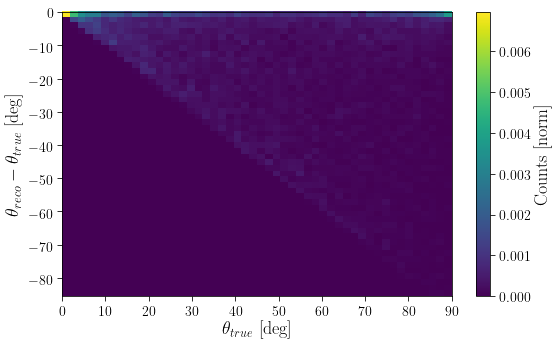

In [19]:
plt.figure(figsize=(8,5))
plt.hist2d(true,reco-true, bins=50, normed=True);
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$ [deg]")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
plt.tight_layout()
# plt.ylim(-10,10)
plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue.pdf')

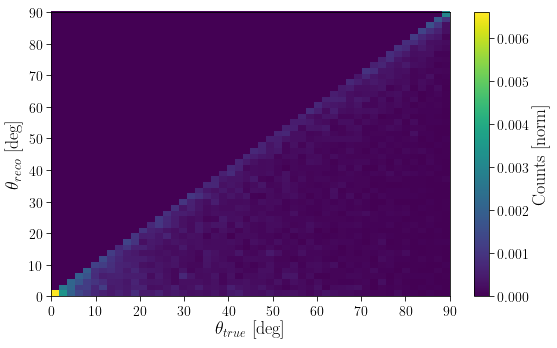

In [20]:
plt.figure(figsize=(8,5))
plt.hist2d(true,reco, bins=50, normed=True);
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$ [deg]")
plt.ylabel("$\\theta_{reco}$ [deg]")
plt.tight_layout()
plt.savefig(my_path_plots+'/Dumpster/deltavsTrue2D.pdf')

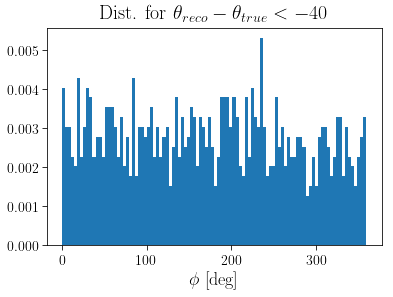

In [32]:
dist = pd.DataFrame({"reco":reco, "true":true, "phi":phi_})
tail = dist.loc[(dist.reco-dist.true)<-40]
# plt.hist(phi_)
plt.hist(tail.phi, bins=100, density=True);
plt.xlabel("$\phi$ [deg]")
plt.title("Dist. for $\\theta_{reco}-\\theta_{true}<-40$")
plt.savefig(my_path_plots+'/Dumpster/phiLtNeg40.pdf')

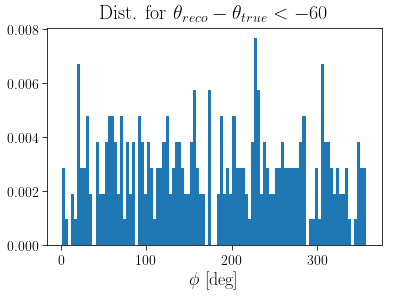

In [33]:
rightTail = dist.loc[(dist.reco-dist.true)<-60]
# plt.hist(phi_)
plt.hist(rightTail.phi, bins=100, density=True);
plt.xlabel("$\phi$ [deg]")
plt.title("Dist. for $\\theta_{reco}-\\theta_{true}<-60$")
plt.savefig(my_path_plots+'/Dumpster/phiLtNeg60.pdf')

Text(0.5,0,'$\\phi$ [deg]')

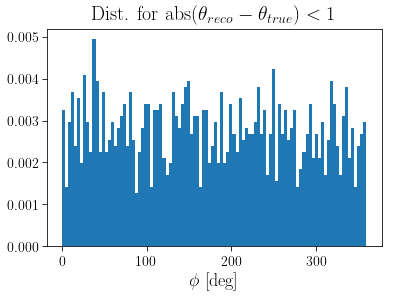

In [24]:
center = dist.loc[dist.reco-dist.true>-1]
plt.title("Dist. for abs$(\\theta_{reco}-\\theta_{true})<1$")
plt.hist(center.phi, bins=100, density=True);
plt.xlabel("$\phi$ [deg]")
# plt.savefig(my_path_plots+'/Stokes/Sep30Call/phiNearPeak.pdf')

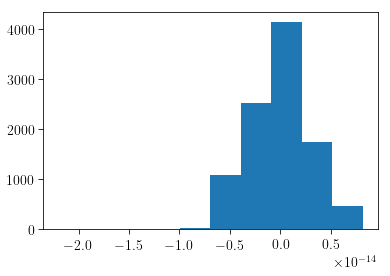

In [25]:
plt.hist(dot);


In [27]:
singleAngle = dist.loc[abs(dist.true-10)<1]

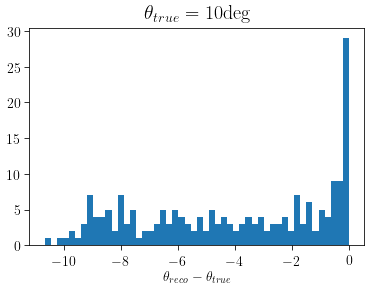

In [31]:
plt.hist(singleAngle.reco-singleAngle.true, bins=50);
plt.title("$\\theta_{true}=10$deg")
plt.xlabel("$\\theta_{reco}-\\theta_{true}$", fontsize=14);
